In [72]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 20,
          'figure.figsize': (15, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 20,
         'ytick.labelsize': 20}
pylab.rcParams.update(params)
plt.close('all')

## Files are stored in the '2015' and '2016' subdirectories, relative to the working directory
path2015 = Path('../2015')
path2016 = Path('../2016')
dp = np.linspace(0,100,11)
dy = np.linspace(1945,2020,15)
pd.options.display.max_columns = None


In [19]:
## Column names in the 2016 version of the Physician Compare National Downloadable File are simple and coding-friendly 
## except for a leading space in all columns after the first. That file is read first and its column names (with leading 
## space removed) used to replace column names of the 2015 version data after its file is read. Numerical columns are read 
## as floats (many have NaNs), except where that failed due to presence of a string. As of now, these are handled, when 
## necessary, on a case-by-case basis. ndf16.dtypes.equals(ndf15.dtypes) returns True.

col_names16 = pd.read_csv(path2016 / 'Physician_Compare_National_Downloadable_File.csv', nrows=0).columns
types_dict = {"NPI": float, " Ind_PAC_ID": float, " Grd_yr": float, " org_pac_id": float, " num_org_mem": float}
types_dict.update({col: str for col in col_names16 if col not in types_dict})
ndf16 = pd.read_csv(path2016 / 'Physician_Compare_National_Downloadable_File.csv', dtype=types_dict).rename(columns=lambda x: x.strip())

'''col_names15 = pd.read_csv(path2015 / 'Physician_Compare_National_Downloadable_File.csv', nrows=0).columns
types_dict = {"NPI": float, "PAC ID": float, "Graduation year": float, "Group Practice PAC ID": float, "Number of Group Practice members": float}
types_dict.update({col: str for col in col_names15 if col not in types_dict})
ndf15 = pd.read_csv(path2015 / 'Physician_Compare_National_Downloadable_File.csv', dtype=types_dict)
ndf15.rename(columns=dict(zip(ndf15.columns.values, ndf16.columns.values)), inplace=True)

## The 2016 version of the Individual physician measured performance rates contains a new column not found in the 2015 version,
## patient count. A patient_count column containing float zeros is added to the 2015 data in matching position to where it is
## ips16.dtypes.equals(ips15.dtypes) returns True.
'''
col_names16 = pd.read_csv(path2016 / 'Physician_Compare_2016_Individual_EP_Public_Reporting.csv', nrows=0).columns
types_dict = {"NPI": float, " Ind_PAC_ID": float, " prf_rate": float, " patient_count": float}
types_dict.update({col: str for col in col_names16 if col not in types_dict})
ips16 = pd.read_csv(path2016 / 'Physician_Compare_2016_Individual_EP_Public_Reporting.csv', dtype=types_dict).rename(columns=lambda x: x.strip())

'''col_names15 = pd.read_csv(path2015 / 'Physician_Compare_2015_Individual_EP_Public_Reporting___Performance_Scores.csv', nrows=0).columns
types_dict = {"NPI": float, "PAC ID": float, "Measure Performance Rate": float}
types_dict.update({col: str for col in col_names15 if col not in types_dict})
ips15 = pd.read_csv(path2015 / 'Physician_Compare_2015_Individual_EP_Public_Reporting___Performance_Scores.csv', dtype=types_dict)
ips15.insert(loc=8, column='patient_count', value=0)
ips15.rename(columns=dict(zip(ips15.columns.values, ips16.columns.values)), inplace=True)

## The Clinician Utilization data is new for 2016.
col_names16 = pd.read_csv(path2016 / 'Physician_Compare_Clinician_Utilization_Data.csv', nrows=0).columns
types_dict = {"NPI": float, " Ind_PAC_ID": float, " line_srvc_cnt": float, " bene_cnt": float}
types_dict.update({col: str for col in col_names16 if col not in types_dict})
cud16 = pd.read_csv(path2016 / 'Physician_Compare_Clinician_Utilization_Data.csv', dtype=types_dict).rename(columns=lambda x: x.strip())
'''

'col_names15 = pd.read_csv(path2015 / \'Physician_Compare_2015_Individual_EP_Public_Reporting___Performance_Scores.csv\', nrows=0).columns\ntypes_dict = {"NPI": float, "PAC ID": float, "Measure Performance Rate": float}\ntypes_dict.update({col: str for col in col_names15 if col not in types_dict})\nips15 = pd.read_csv(path2015 / \'Physician_Compare_2015_Individual_EP_Public_Reporting___Performance_Scores.csv\', dtype=types_dict)\nips15.insert(loc=8, column=\'patient_count\', value=0)\nips15.rename(columns=dict(zip(ips15.columns.values, ips16.columns.values)), inplace=True)\n\n## The Clinician Utilization data is new for 2016.\ncol_names16 = pd.read_csv(path2016 / \'Physician_Compare_Clinician_Utilization_Data.csv\', nrows=0).columns\ntypes_dict = {"NPI": float, " Ind_PAC_ID": float, " line_srvc_cnt": float, " bene_cnt": float}\ntypes_dict.update({col: str for col in col_names16 if col not in types_dict})\ncud16 = pd.read_csv(path2016 / \'Physician_Compare_Clinician_Utilization_Data.csv

In [121]:
#ips16.head()
#Will go back and clean up data later, will proceed now with a cursory cleanup done.
ndf16.head()
#for idx, row in enumerate(ndf16):
#    npi[idx] = ndf16.NPI[idx]
ndf16t = ndf16.loc[:, 'NPI':'pri_spec'].drop_duplicates()
type(ndf16t)
#ndf16.head()
#ndf16.NPI.drop_duplicates().count()

pandas.core.frame.DataFrame

In [124]:
ndf16t.loc[:, 'pri_spec'].value_counts()


NURSE PRACTITIONER                                    121561
INTERNAL MEDICINE                                      94231
FAMILY MEDICINE                                        84988
PHYSICIAN ASSISTANT                                    69856
PHYSICAL THERAPY                                       55495
CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)          42160
CHIROPRACTIC                                           39538
ANESTHESIOLOGY                                         38597
CLINICAL SOCIAL WORKER                                 37908
DIAGNOSTIC RADIOLOGY                                   35530
OPTOMETRY                                              31977
OBSTETRICS/GYNECOLOGY                                  31556
PSYCHOLOGIST, CLINICAL                                 25777
ORTHOPEDIC SURGERY                                     23293
PSYCHIATRY                                             22598
CARDIOVASCULAR DISEASE (CARDIOLOGY)                    21489
GENERAL SURGERY         

In [ ]:
#isin(values)	Whether each element in the DataFrame is contained in values.


In [126]:
ndf16.loc[ndf16.PQRS == 'Y', :].count()


NPI               1378871
Ind_PAC_ID        1378871
Ind_enrl_ID       1378871
lst_nm            1378857
frst_nm           1378851
mid_nm            1057307
suff                28404
gndr              1378871
Cred               505243
Med_sch           1378868
Grd_yr            1375159
pri_spec          1378871
sec_spec_1         229741
sec_spec_2          25497
sec_spec_3           2486
sec_spec_4            340
sec_spec_all       229741
org_nm            1326581
org_pac_id        1326581
num_org_mem       1326581
adr_ln_1          1378871
adr_ln_2           455747
ln_2_sprs           98320
cty               1378871
st                1378871
zip               1378871
phn_numbr         1163172
hosp_afl_1        1142064
hosp_afl_lbn_1    1141643
hosp_afl_2         615399
hosp_afl_lbn_2     614720
hosp_afl_3         341981
hosp_afl_lbn_3     341521
hosp_afl_4         201975
hosp_afl_lbn_4     201569
hosp_afl_5         128582
hosp_afl_lbn_5     128264
assgn             1378871
PQRS        

In [129]:
num_unique_providers_in_ndf = ndf16t.NPI.drop_duplicates().count()
num_unique_providers_in_ips = ips16.NPI.drop_duplicates().count()
num_patients_treated = ips16.patient_count.sum()
num_measures = ips16.measure_ID.drop_duplicates().count()
num_phys_specialties = ndf16t.pri_spec.drop_duplicates().count()

num_unique_providers_in_ndf, num_unique_providers_in_ips, num_patients_treated, num_measures, num_phys_specialties

(1051588, 126054, 82207304.0, 94, 83)

In [127]:
phys_specialties = ndf16t.pri_spec.drop_duplicates()
med_schools = ndf16t.Med_sch.drop_duplicates()
measure_num_name_pairs = ips16[['measure_ID', 'measure_title']].drop_duplicates()
measure_num_name_pairs

#med_schools.drop_duplicates().to_csv('../med_sch.csv', index=False)
#measure_num_name_pairs.drop_duplicates().to_csv('../measuretitles.csv', index=False)
#phys_specialties.drop_duplicates().to_csv('../phys_specialties.csv', index=False)

#phys_specialties
#ips16[ips16['NPI','measure_ID']]

,measure_ID,measure_title
0,PQRS_EP_110_1,Preventive Care and Screening: Influenza Immun...
1,PQRS_EP_111_1,Pneumonia Vaccination Status for Older Adults
2,PQRS_EP_113_1,Colorectal Cancer Screening
3,PQRS_EP_130_1,Documentation of Current Medications in the Me...
4,PQRS_EP_226_1,Preventive Care and Screening: Tobacco Use: Sc...
5,PQRS_EP_39_1,Screening or Therapy for Osteoporosis for Wome...
6,PQRS_EP_48_1,Urinary Incontinence: Assessment of Presence o...
7,PQRS_EP_47_1,Advance Care Plan
13,PQRS_EP_131_1,Pain Assessment and Follow-Up
14,PQRS_EP_182_1,Functional Outcome Assessment


# Figure 1

[Text(0, 0.5, 'Clinician participation rate'),
 Text(0.5, 0, "Year of Clinician's Terminal Degree")]

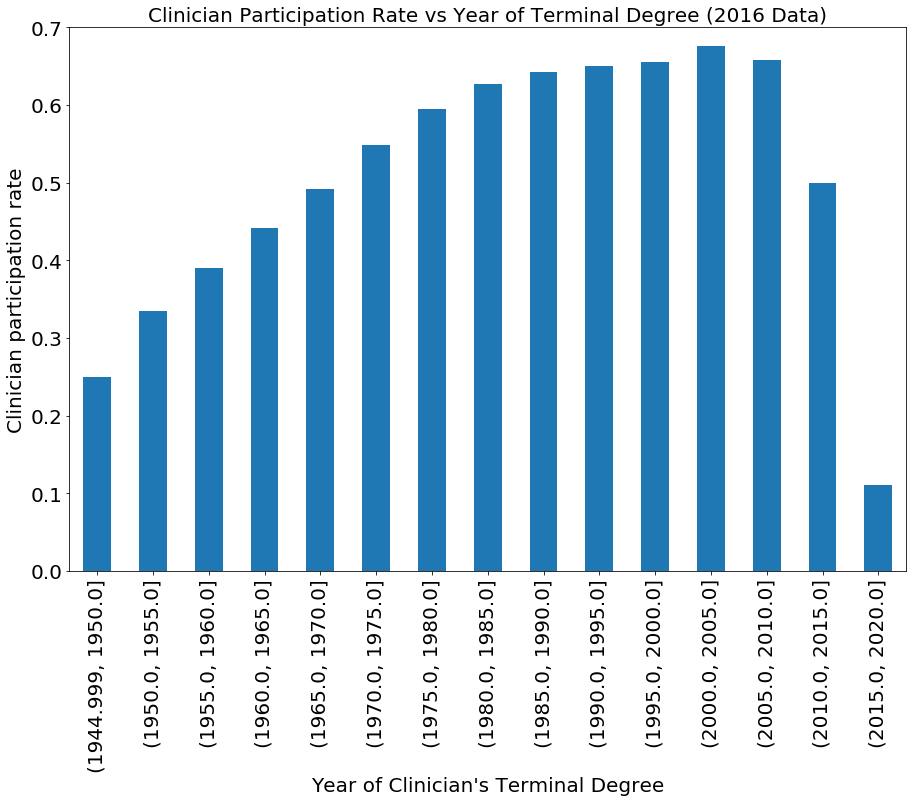

In [27]:
dy = np.linspace(1945,2020,16)
a16 = pd.value_counts(ndf16.loc[(ndf16['PQRS']=='Y'),['NPI','Grd_yr']].drop_duplicates().dropna().Grd_yr, bins=dy, sort=False)
b16 = pd.value_counts(ndf16[['NPI','Grd_yr']].drop_duplicates().dropna().Grd_yr, bins=dy, sort=False)
c16 = a16/b16
ax = c16.plot.bar(ylim=(0,0.7), title='Clinician Participation Rate vs Year of Terminal Degree (2016 Data)')
ax.set(xlabel="Year of Clinician's Terminal Degree", ylabel="Clinician participation rate")

# Figure 2

[Text(0, 0.5, 'Clinician participation rate'),
 Text(0.5, 0, "Year of Clinician's Terminal Degree")]

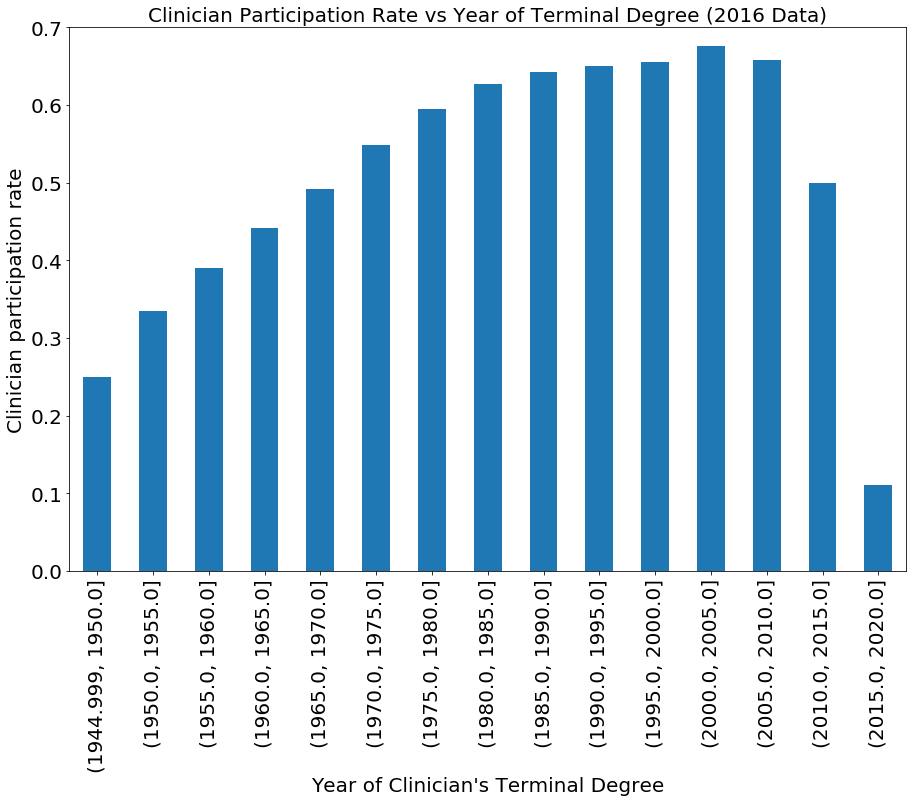

In [28]:
a16 = pd.value_counts(ndf16.loc[(ndf16['PQRS']=='Y'),['NPI','Grd_yr']].drop_duplicates().dropna().Grd_yr, bins=dy, sort=False)
b16 = pd.value_counts(ndf16[['NPI','Grd_yr']].drop_duplicates().dropna().Grd_yr, bins=dy, sort=False)
c16 = a16/b16
ax = c16.plot.bar(ylim=(0,0.7), title='Clinician Participation Rate vs Year of Terminal Degree (2016 Data)')
ax.set(xlabel="Year of Clinician's Terminal Degree", ylabel="Clinician participation rate")

# Figure 3

In [11]:
ax = (c16/c15).iloc[0:13].plot.bar(ylim=(0.9,1.1), title='Participation rate change vs year of terminal degree (2016 data vs 2015 data)')
ax.set(xlabel="Year of Clinician's Terminal Degree", ylabel="Clinician participation rate year over year change")
#print((c16/c15).iloc[0:13])

NameError: name 'c16' is not defined

In [30]:
## This code section examines Pneumonia Vaccination Status for Older Adults
## Need to explore weighting performance scores by patient count for 2016 data, will be interesting to contrast with the 2015 
## data where patient count is not available

a = ips16.loc[(ips16['measure_ID']=='PQRS_EP_111_1'),['NPI','prf_rate','patient_count']].drop_duplicates().dropna()

b1 = ndf16.loc[(ndf16['pri_spec']=='INTERNAL MEDICINE'),['NPI']].drop_duplicates().dropna()
c1 = pd.merge(a, b1, on='NPI')

b2 = ndf16.loc[(ndf16['pri_spec']=='INFECTIOUS DISEASE'),['NPI']].drop_duplicates().dropna()
c2 = pd.merge(a, b2, on='NPI')

b3 = ndf16.loc[(ndf16['pri_spec']=='EMERGENCY MEDICINE'),['NPI']].drop_duplicates().dropna()
c3 = pd.merge(a, b3, on='NPI')

b4 = ndf16.loc[(ndf16['pri_spec']=='PULMONARY DISEASE'),['NPI']].drop_duplicates().dropna()
c4 = pd.merge(a, b4, on='NPI')

b5 = ndf16.loc[(ndf16['pri_spec']=='NURSE PRACTITIONER'),['NPI']].drop_duplicates().dropna()
c5 = pd.merge(a, b5, on='NPI')

b6 = ndf16.loc[(ndf16['pri_spec']=='MEDICAL ONCOLOGY'),['NPI']].drop_duplicates().dropna()
c6 = pd.merge(a, b6, on='NPI')

b7 = ndf16.loc[(ndf16['pri_spec']=='GENERAL PRACTICE'),['NPI']].drop_duplicates().dropna()
c7 = pd.merge(a, b7, on='NPI')

b8 = ndf16.loc[(ndf16['pri_spec']=='PHYSICIAN ASSISTANT'),['NPI']].drop_duplicates().dropna()
c8 = pd.merge(a, b8, on='NPI')


print(scipy.stats.describe(c1.prf_rate))
print(scipy.stats.describe(c2.prf_rate))
print(scipy.stats.describe(c3.prf_rate))
print(scipy.stats.describe(c4.prf_rate))
print(scipy.stats.describe(c5.prf_rate))
print(scipy.stats.describe(c6.prf_rate))
print(scipy.stats.describe(c7.prf_rate))
print(scipy.stats.describe(c8.prf_rate))

print(stats.ttest_ind(c1.prf_rate,c2.prf_rate,equal_var=False))
print(stats.ttest_ind(c1.prf_rate,c3.prf_rate,equal_var=False))
print(stats.ttest_ind(c1.prf_rate,c4.prf_rate,equal_var=False))
print(stats.ttest_ind(c2.prf_rate,c3.prf_rate,equal_var=False))
print(stats.ttest_ind(c2.prf_rate,c4.prf_rate,equal_var=False))
print(stats.ttest_ind(c3.prf_rate,c4.prf_rate,equal_var=False))
print(stats.ttest_ind(c5.prf_rate,c8.prf_rate,equal_var=False))
print(stats.ttest_ind(c2.prf_rate,c7.prf_rate,equal_var=False))
print(stats.ttest_ind(c1.prf_rate,c5.prf_rate,equal_var=False))
print(stats.ttest_ind(c1.prf_rate,c8.prf_rate,equal_var=False))
print(1-58.85706462212487/75.30104623692203)
print(1-59.421996879875195/75.30104623692203)
print(1-62.54601226993865/75.30104623692203)
print(1-63.55072463768116/75.30104623692203)

DescribeResult(nobs=2674, minmax=(0.0, 100.0), mean=78.44053851907255, variance=494.96110947419845, skewness=-1.3069308230936787, kurtosis=1.207887013377726)
DescribeResult(nobs=160, minmax=(1.0, 100.0), mean=65.8625, variance=605.5155660377359, skewness=-0.3823692887118183, kurtosis=-0.5788443314132583)
DescribeResult(nobs=107, minmax=(0.0, 100.0), mean=52.03738317757009, variance=964.8287779932992, skewness=-0.10529309249863313, kurtosis=-1.2120910983107471)
DescribeResult(nobs=536, minmax=(7.0, 100.0), mean=76.72388059701493, variance=491.83015762309935, skewness=-0.8584214816791872, kurtosis=-0.12027120964760574)
DescribeResult(nobs=1880, minmax=(0.0, 100.0), mean=62.250531914893614, variance=612.3539113720517, skewness=-0.45308700153474324, kurtosis=-0.5367336980860773)
DescribeResult(nobs=64, minmax=(11.0, 100.0), mean=72.015625, variance=618.2061011904761, skewness=-0.4461789228037137, kurtosis=-0.9317319032853906)
DescribeResult(nobs=65, minmax=(10.0, 100.0), mean=69.7230769230

# Pneumonia Results

# It has been estimated that the total annual excess cost of hospital-treated pneumonia as a primary diagnosis in the elderly fee-for-service Medicare population in 2010 exceeded 7 billion dollars.

# Takeaways from the above cursory comparisons of how clinicians of one primary specialty perform relative to clinicians of another primary specialty regarding how they advise their patients on Pneumonia Vaccination. 

# Physician Assistants (PAs) and Nurse Practitioners (NPs) do similarly well (p = 0.57) but both do significantly poorer than those whose primary specialty was Internal Medicine, with mean score 20% lower

# Surprisingly, those whose primary specialty was Infectious Disease did significantly worse than Internal Medicine (p = 3e-08, Infectious Disease mean score 17% lower) and  Pulmonary Disease (p = 2e-05, Infectious Disease mean score 16% lower), but similarly to General Medicine (p = 0.8).


In [ ]:
female = df1.loc[(df1["Gender"]=="F"), ["Gender"]]
female_accept = df1.loc[(df1["Gender"]=="F") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","PAC ID","Medical school name","Graduation year"]]
male = df1.loc[(df1["Gender"]=="M"), ["Gender"]]
male_accept = df1.loc[(df1["Gender"]=="M") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","PAC ID","Medical school name","Graduation year"]]
am = df1.loc[(df1["Gender"]=="M") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","Medical school name","Graduation year"]]
af = df1.loc[(df1["Gender"]=="F") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","Medical school name","Graduation year"]]
df2_flu = df2.loc[(df2["Measure Title"]=="Preventive Care and Screening: Influenza Immunization"),["NPI","Measure Performance Rate"]]
df3_pneuvacc = df2.loc[(df2["Measure Title"]=="Pneumonia Vaccination Status for Older Adults"),["NPI","Measure Performance Rate"]]
df4_brcanc = df2.loc[(df2["Measure Title"]=="Breast Cancer Screening"),["NPI","Measure Performance Rate"]]
df5_colocanc = df2.loc[(df2["Measure Title"]=="Colorectal Cancer Screening"),["NPI","Measure Performance Rate"]]
df6_bmi = df2.loc[(df2["Measure Title"]=="Preventive Care and Screening: Body Mass Index (BMI) Screening and Follow-Up Plan"),["NPI","Measure Performance Rate"]]
df7_currmeds = df2.loc[(df2["Measure Title"]=="Documentation of Current Medications in the Medical Record"),["NPI","Measure Performance Rate"]]
df8_eldmal = df2.loc[(df2["Measure Title"]=="Elder Maltreatment Screen and Follow-Up Plan"),["NPI","Measure Performance Rate"]]
df9_tobacco = df2.loc[(df2["Measure Title"]=="Preventive Care and Screening: Tobacco Use: Screening and Cessation Intervention"),["NPI","Measure Performance Rate"]]
df10_osteo = df2.loc[(df2["Measure Title"]=="Screening or Therapy for Osteoporosis for Women Aged 65 Years and Older"),["NPI","Measure Performance Rate"]]
df11_ecg = df2.loc[(df2["Measure Title"]=="Emergency Medicine: 12-Lead Electrocardiogram (ECG) Performed for Non-Traumatic Chest Pain"),["NPI","Measure Performance Rate"]]

brcancm=pd.merge(am, df4_brcanc, on='NPI').drop_duplicates().dropna()
brcancf=pd.merge(af, df4_brcanc, on='NPI').drop_duplicates().dropna()



In [6]:
colocanc_tobacco=pd.merge(ips15.loc[(ips15['measure_title']=='Colorectal Cancer Screening'),['NPI','prf_rate']],ips15.loc[(ips15['measure_title']=='Preventive Care and Screening: Tobacco Use: Screening and Cessation Intervention'),['NPI','prf_rate']], on='NPI').drop_duplicates().dropna()
flu_pneuvacc=pd.merge(ips15.loc[(ips15['measure_title']=='Preventive Care and Screening: Influenza Immunization'),['NPI','prf_rate']],ips15.loc[(ips15['measure_title']=='Pneumonia Vaccination Status for Older Adults'),['NPI','prf_rate']], on='NPI').drop_duplicates().dropna()
brcancm = pd.merge(ips15.loc[(ips15['measure_title']=='Breast Cancer Screening'),['NPI','prf_rate']],ndf15.loc[(ndf15.gndr=='M'),['NPI','Grd_yr']],on='NPI').drop_duplicates().dropna()
brcancf = pd.merge(ips15.loc[(ips15['measure_title']=='Breast Cancer Screening'),['NPI','prf_rate']],ndf15.loc[(ndf15.gndr=='F'),['NPI','Grd_yr']],on='NPI').drop_duplicates().dropna()
flum = pd.merge(ips15.loc[(ips15['measure_title']=='Preventive Care and Screening: Influenza Immunization'),['NPI','prf_rate']],ndf15.loc[(ndf15.gndr=='M'),['NPI','Grd_yr']],on='NPI').drop_duplicates().dropna()
fluf = pd.merge(ips15.loc[(ips15['measure_title']=='Preventive Care and Screening: Influenza Immunization'),['NPI','prf_rate']],ndf15.loc[(ndf15.gndr=='F'),['NPI','Grd_yr']],on='NPI').drop_duplicates().dropna()

NameError: name 'ips15' is not defined

# Figure 4

In [5]:
ax = colocanc_tobacco.plot.scatter(x='prf_rate_x',y='prf_rate_y',title='Coincidence of performance scores in Colon Cancer Prevention and Smoking Intervention')
ax.set(xlabel='Colon Cancer Screening performance rate', ylabel='Smoking Intervention')
print(scipy.stats.describe(colocanc_tobacco.prf_rate_x))
print(scipy.stats.describe(colocanc_tobacco.prf_rate_y))
print(stats.ttest_ind(colocanc_tobacco.prf_rate_x,colocanc_tobacco.prf_rate_y,equal_var=False))

NameError: name 'colocanc_tobacco' is not defined

# Statistical analysis confirms the surprising result seen above. Clinicians who had scores in both categories did an excellent job of counseling their patients with regards to Smoking Cessation (mean value ~95), but those same clinicians did much more poorly when it came to Colorectal Cancer Screening (mean value ~56). Colorectal cancers affect mosly older adults, and the prognosis of those suffering from such cancers drops sharply with disease progression. 

# Figure 5

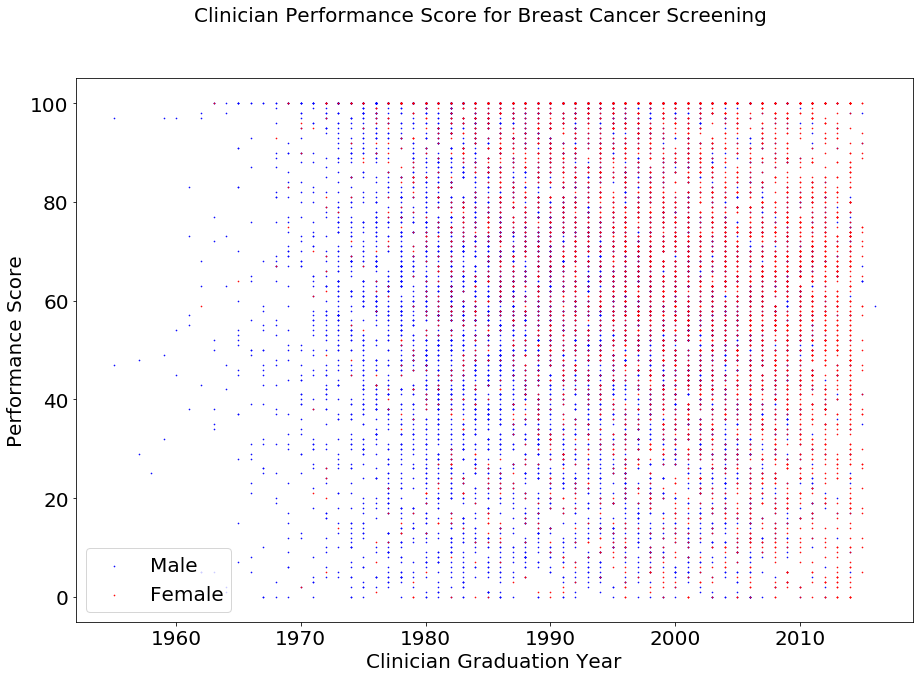

In [491]:
fig=plt.figure()
fig.suptitle('Clinician Performance Score for Breast Cancer Screening', fontsize=20)
plt.xlabel('Clinician Graduation Year')
plt.ylabel('Performance Score')
ax1=plt.scatter(brcancm.Grd_yr, brcancm.prf_rate, c='blue', s=0.4, label='Male')
ax2=plt.scatter(brcancf.Grd_yr, brcancf.prf_rate, c='red', s=0.4, label='Female')
plt.gca().legend()
plt.show()

# Figure 6

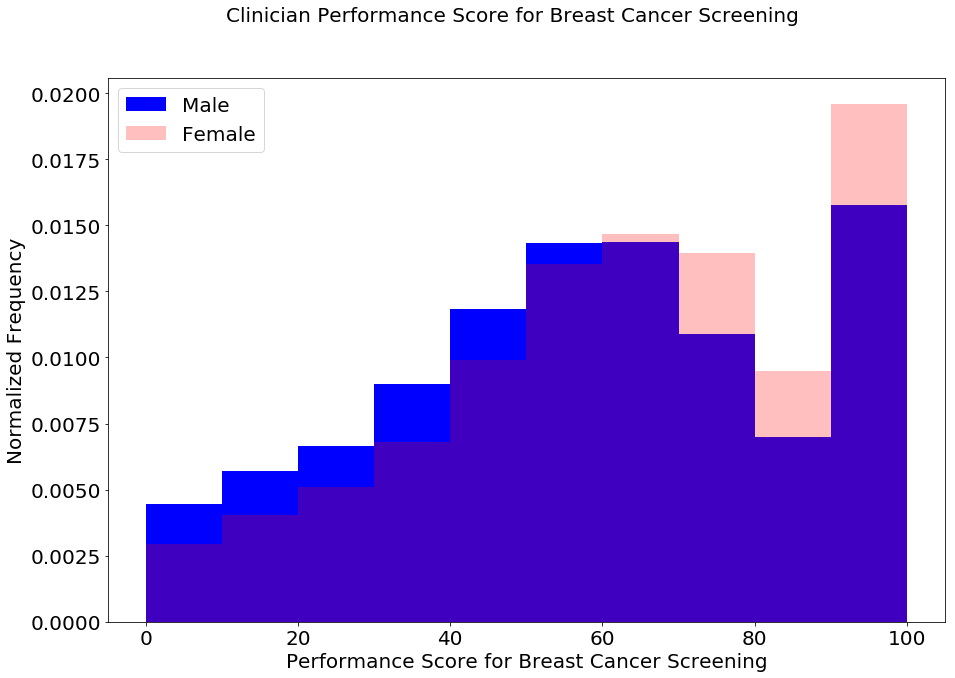

Ttest_indResult(statistic=-11.742784421363774, pvalue=1.164939644567891e-31)
DescribeResult(nobs=7528, minmax=(0.0, 100.0), mean=57.528294367693945, variance=715.0880793542821, skewness=-0.14425095094601056, kurtosis=-0.7955300307913813)
DescribeResult(nobs=5244, minmax=(0.0, 100.0), mean=63.06273836765828, variance=666.7160707757087, skewness=-0.39487096490851764, kurtosis=-0.5926183306720234)
0.08776092100058042


In [481]:
fig=plt.figure()
fig.suptitle('Clinician Performance Score for Breast Cancer Screening',fontsize=20)
plt.xlabel('Performance Score for Breast Cancer Screening')
plt.ylabel('Normalized Frequency')
ax1=plt.hist(brcancm.prf_rate, label="Male", bins=dp, color='blue', normed=True)
ax2=plt.hist(brcancf.prf_rate, label="Female", bins=dp, color='red', normed=True, alpha=0.25)
plt.gca().legend()
plt.show()
print(stats.ttest_ind(brcancm.prf_rate,brcancf.prf_rate,equal_var=False))
print(scipy.stats.describe(brcancm.prf_rate))
print(scipy.stats.describe(brcancf.prf_rate))
print(1-57.528294367693945/63.06273836765828)

# Female clinicians perform significantly (p = 1e-31) better at Breast Cancer Screening than do their Male counterparts, with the Male mean score ~9% lower than that of the Female mean score. 

# Figure 7

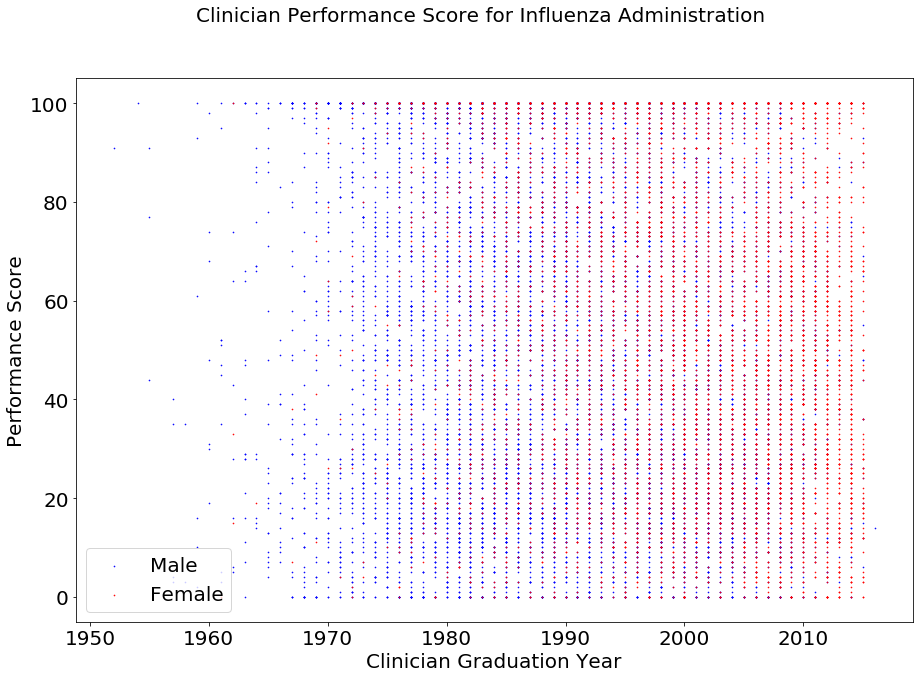

In [492]:
fig=plt.figure()
fig.suptitle('Clinician Performance Score for Influenza Administration', fontsize=20)
plt.xlabel('Clinician Graduation Year')
plt.ylabel('Performance Score')
ax1=plt.scatter(flum.Grd_yr, flum.prf_rate, c='blue', s=0.4, label='Male')
ax2=plt.scatter(fluf.Grd_yr, fluf.prf_rate, c='red', s=0.4, label='Female')
plt.gca().legend()
plt.show()

# Figure 8

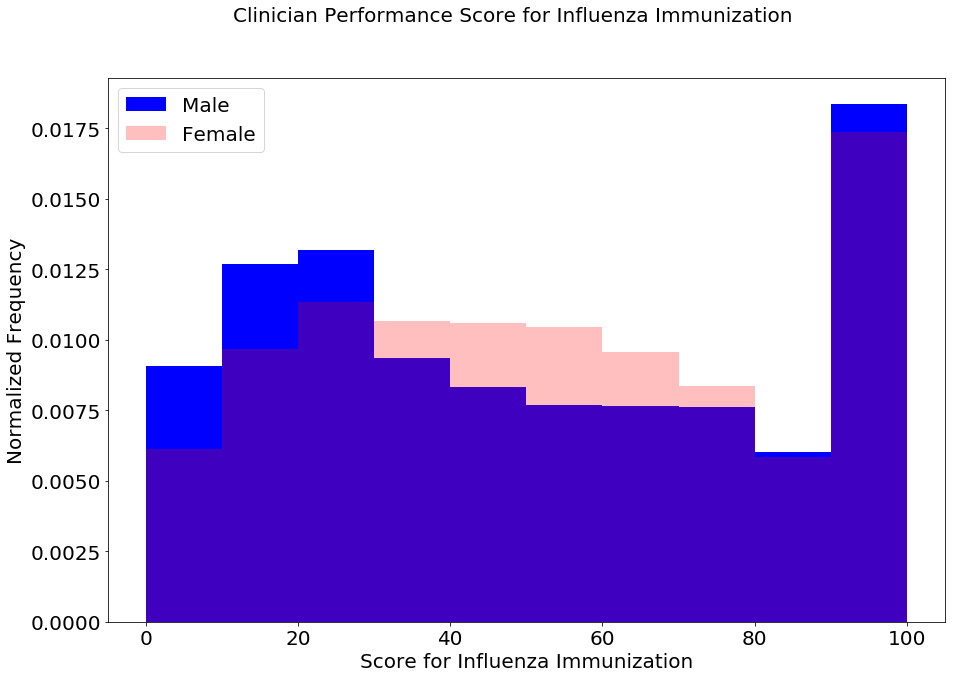

Ttest_indResult(statistic=-5.394371800113707, pvalue=6.987824893386015e-08)
DescribeResult(nobs=10265, minmax=(0.0, 100.0), mean=50.27608377983439, variance=1028.5656253476177, skewness=0.19657507614103678, kurtosis=-1.2944008882951454)
DescribeResult(nobs=6285, minmax=(0.0, 100.0), mean=52.92633253778838, variance=887.2744894915653, skewness=0.11023588849393222, kurtosis=-1.1434983822602929)
0.05007429441784517


In [497]:
fig=plt.figure()
fig.suptitle('Clinician Performance Score for Influenza Immunization',fontsize=20)
plt.xlabel('Score for Influenza Immunization')
plt.ylabel('Normalized Frequency')
ax1=plt.hist(flum.prf_rate, label="Male", bins=dp, color='blue', normed=True)
ax2=plt.hist(fluf.prf_rate, label="Female", bins=dp, color='red', normed=True, alpha=0.25)
plt.gca().legend()
plt.show()
print(stats.ttest_ind(flum.prf_rate,fluf.prf_rate,equal_var=False))
print(scipy.stats.describe(flum.prf_rate))
print(scipy.stats.describe(fluf.prf_rate))
print(1-scipy.stats.describe(flum.prf_rate).mean/scipy.stats.describe(fluf.prf_rate).mean)

# Female clinicians perform significantly (p = 7e-08) better at Influenza Immunization than do their Male counterparts, with the Male mean score ~5% lower than that of the Female mean score.

In [ ]:
dy = np.linspace(1945,2020,16)
a15 = pd.value_counts(ndf15.loc[(ndf15['PQRS']=='Y'),['NPI','Grd_yr']].drop_duplicates().dropna().Grd_yr, bins=dy, sort=False)
b15 = pd.value_counts(ndf15[['NPI','Grd_yr']].drop_duplicates().dropna().Grd_yr, bins=dy, sort=False)
c15 = a15/b15
ax = c15.plot.bar(ylim=(0,0.7), title='Clinician Participation Rate vs Year of Terminal Degree (2015 Data)')
ax.set(xlabel="Year of Clinician's Terminal Degree", ylabel="Clinician participation rate")

# Figure 9

DescribeResult(nobs=14421, minmax=(0.0, 100.0), mean=50.785035711809165, variance=907.0571158603751, skewness=0.20495861604273377, kurtosis=-1.180138997259932)
DescribeResult(nobs=14421, minmax=(0.0, 100.0), mean=61.84245197975175, variance=692.7853017266294, skewness=-0.3638483677479114, kurtosis=-0.8381174970607961)
Ttest_indResult(statistic=-33.19806295216166, pvalue=4.0343688962106085e-237)
0.17879977125685387


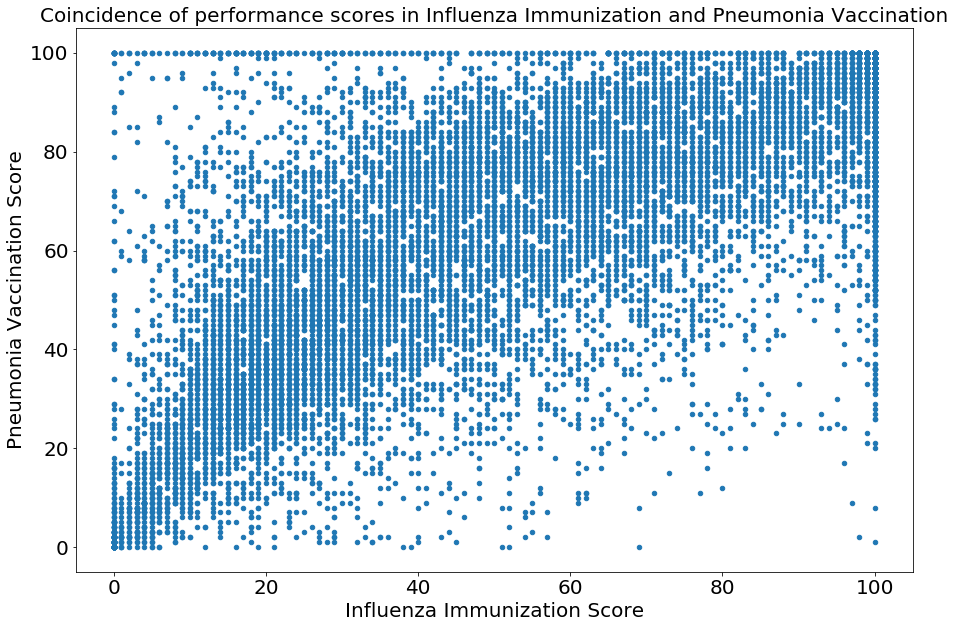

In [495]:
ax = flu_pneuvacc.plot.scatter(x='prf_rate_x',y='prf_rate_y',title='Coincidence of performance scores in Influenza Immunization and Pneumonia Vaccination')
ax.set(xlabel='Influenza Immunization Score', ylabel='Pneumonia Vaccination Score')
print(scipy.stats.describe(flu_pneuvacc.prf_rate_x))
print(scipy.stats.describe(flu_pneuvacc.prf_rate_y))
print(stats.ttest_ind(flu_pneuvacc.prf_rate_x,flu_pneuvacc.prf_rate_y,equal_var=False))
print(1-scipy.stats.describe(flu_pneuvacc.prf_rate_x).mean/scipy.stats.describe(flu_pneuvacc.prf_rate_y).mean)

# On average clinicians do a significantly worse (p = 4e-237) job counseling their patients regarding Influenza Vaccination (mean score = 50.8, 18% lower than for Pneumonia Vaccination) than they do regarding Pneumonia Vaccination (mean score = 61.8). 

# In Progress, need to vectorize loops(!) and extend into the measure_ID dimension

In [394]:
## This section collects descriptive statistics on the performance data of clinicians by their primary specialty, generating a
## dataframe in which the columns are specialties and the columns are the various measurement categories covered by the PQRS
## As of now this works on only a single category, and compares clinician primary specialties within that category.
## This needs to be vectorized badly, extremely slow as nested for loops.

spec_list = ndf15.pri_spec.unique()
measure_ID_list = ips15.measure_ID.unique()
spec_mid_descstat = pd.DataFrame(index=np.arange(0, len(spec_list)), columns=measure_ID_list)

for i in range(0, len(measure_ID_list)):
    a = ips15.loc[(ips15['measure_ID']==measure_ID_list[i]),['NPI', 'prf_rate', 'patient_count']].drop_duplicates().dropna()
    for j in range(0, len(spec_list)):
        b = ndf15.loc[(ndf15['pri_spec']==spec_list[j]),['NPI']].drop_duplicates().dropna()
        c = pd.merge(a, b, on='NPI')
        if not c.prf_rate.empty:
            d = scipy.stats.describe(c.prf_rate)
            e = c.patient_count.sum()
            spec_mid_descstat.iat[j,i] = d


C:\Users\Huawei\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\Huawei\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                                       PQRS_EP_110_1 PQRS_EP_111_1  \
0                                                NaN           NaN   
1                                                NaN           NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...           NaN   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...           NaN   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...           NaN   

  PQRS_EP_112_1 PQRS_EP_113_1 PQRS_EP_128_1 PQRS_EP_130_1 PQRS_EP_181_1  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

  PQRS_EP_226_1 PQRS_EP_39_1 PQRS_EP_317_1  ... PQRS_EP_223_1 PQRS_EP_172_1  \
0           NaN          NaN           NaN  ...  

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

                                       PQRS_EP_110_1  \
0                                                NaN   
1                                                NaN   
2  (157, (0.0, 100.0), 40.904458598726116, 824.57...   
3  (1671, (0.0, 100.0), 48.562537402752845, 866.5...   
4  (2577, (0.0, 100.0), 65.6406674427629, 768.139...   

                                       PQRS_EP_111_1  \
0                                                NaN   
1                                                NaN   
2  (197, (1.0, 100.0), 61.31979695431472, 591.534...   
3  (1826, (0.0, 100.0), 58.85706462212487, 747.91...   
4  (2963, (0.0, 100.0), 75.30104623692203, 591.94...   

                                       PQRS_EP_112_1  \
0                                                NaN   
1                                                NaN   
2  (104, (0.0, 100.0), 52.72115384615385, 609.465...   
3  (1224, (0.0, 100.0), 56.450980392156865, 650.4...   
4  (2306, (0.0, 100.0), 70.56157849089333, 593

In [424]:
## Ttests between specialties for a given performance measure

spec_mid_ttests = pd.DataFrame(index=spec_list, columns=spec_list)

for i in range(0, len(spec_list)):
    for j in range(0, len(spec_list)):
        if not pd.isnull(spec_mid_descstat.iat[i,0])|pd.isnull(spec_mid_descstat.iat[j,0]) :
            d = scipy.stats.ttest_ind_from_stats(mean1=spec_mid_descstat.iat[i,0].mean, std1=np.sqrt(spec_mid_descstat.iat[i,0].variance), nobs1=spec_mid_descstat.iat[i,0].nobs, mean2=spec_mid_descstat.iat[j,0].mean, std2=np.sqrt(spec_mid_descstat.iat[j,0].variance), nobs2=spec_mid_descstat.iat[j,0].nobs, equal_var=False)
            spec_mid_ttests.iat[j,i] = d
        else:
            spec_mid_ttests.iat[j,i] = d

In [431]:
#spec_mid_ttests
# Construct heatmap using pvalues?
spec_mid_ttests.iat[3,0].pvalue

0.01553552431040508